In [126]:
import numpy as np
import pandas as pd
import random

from trmf import trmf
from synthetic_data import SyntheticData

from Forecast import AutoRegressionModel, NaiveModel, MeanModel
from RollingCV import RollingCV, get_slice

import matplotlib.pyplot as plt
%matplotlib inline

## Synthetic data

In [22]:
N = 16
T = 128
K = 4
lags = [1,8]
L = len(lags)
sigma_w = 0.5
sigma_x = 0.1
sigma_t = 0.0

sd = SyntheticData(N, T, K, lags, sigma_w, sigma_x, sigma_t, seed=2)
sd.synthesize_data()
data = sd.get_data()

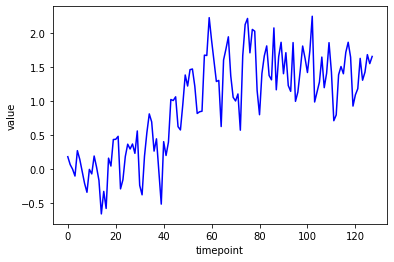

In [23]:
plt.figure()
plt.plot(data[0], color='blue')

plt.xlabel('timepoint')
plt.ylabel('value')

plt.show()

In [24]:
# TRMF model
lambda_f = 1.
lambda_x = 1.
lambda_w = 1.
eta = 1.
alpha = 1000.
max_iter = 5000

for h in [1]:
    model = trmf(lags, K, lambda_f, lambda_x, lambda_w, alpha, eta, max_iter)
    scores_nd = RollingCV(model, data, T-9-h, h, T_step=1, metric='ND')
    scores_nrmse = RollingCV(model, data, T-9-h, h, T_step=1, metric='NRMSE')
    print('TRMF performance ND/NRMSE (h = {}): {}/{}'.format(h, round(np.array(scores_nd).mean(),3),\
                                                    round(np.array(scores_nrmse).mean(),3)))

TRMF performance ND/NRMSE (h = 1): 0.33/0.443


## Electricity

In [25]:
electricity = pd.read_table('../data/LD2011_2014.txt', sep=';', decimal=',')
electricity.head()

,Unnamed: 0,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
0,2011-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2011-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2011-01-01 00:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2011-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2011-01-01 01:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
# transpose and sum by hours
data = electricity.values[:,1:].T.reshape((35064*370,4)).sum(axis=1).reshape((370,35064))[:,10064:].astype(float)[:, -750:]
data.shape

(370, 750)

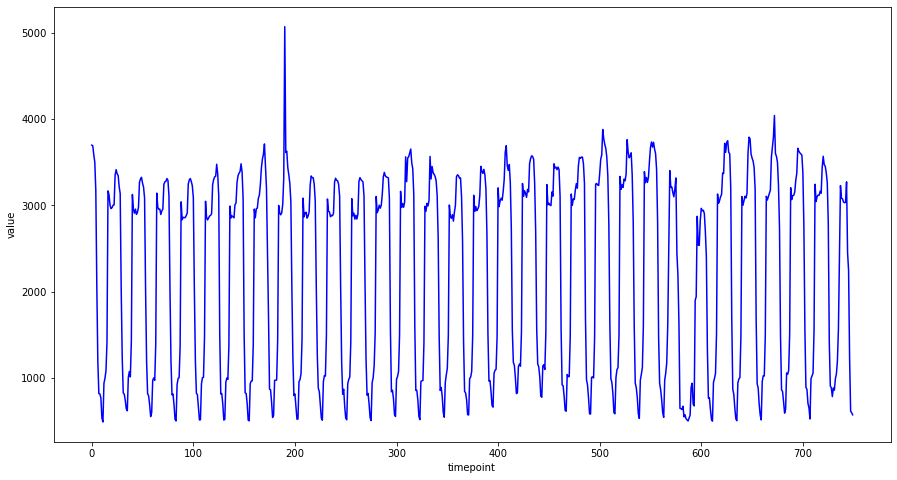

In [27]:
plt.figure(figsize=(15,8))
plt.plot(data[100], color='blue')

plt.xlabel('timepoint')
plt.ylabel('value')

plt.show()

In [210]:
N = 370
T = 750
K = 8
lags = [1] #[i+1 for i in range(24)]+[i+7*24 for i in range(24)]
L = len(lags)

In [216]:
lambda_f = 2.
lambda_x = 2.
lambda_w = 2.
eta = 1.
alpha = 1000.
model = trmf(lags, K, lambda_f, lambda_x, lambda_w, alpha, eta, max_iter=1000)

In [217]:
train, test = get_slice(data, 24*7, 24, 500)

In [218]:
model.fit(train)

In [219]:
pred = model.predict(24)
abs(pred-test).mean()

0.8391684394235281

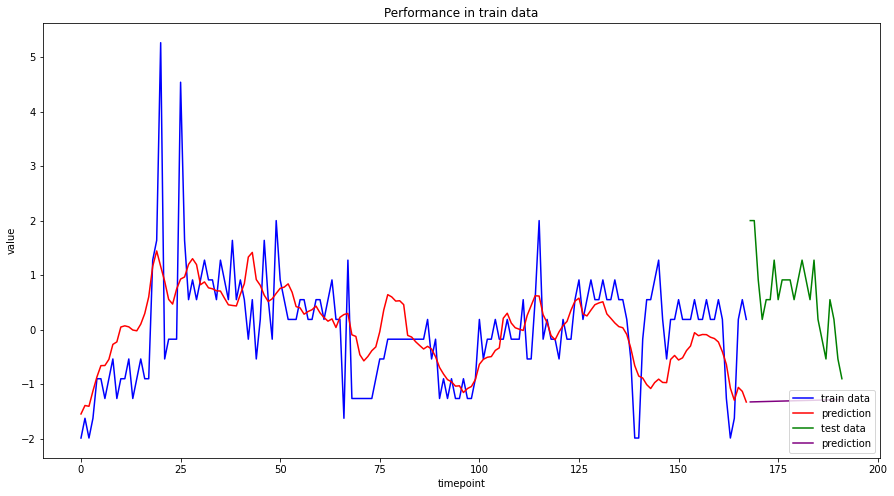

In [220]:
train_preds = np.dot(model.F, model.X)
test_preds = model.predict(24)

plt.figure(figsize=(15,8))
plt.plot(train[0], label='train data', color='blue')
plt.plot(train_preds[0], label='prediction', color='red')

plt.plot([i+24*7 for i in range(24)], test[0], label="test data", color="green")
plt.plot([i+24*7 for i in range(24)], test_preds[0], label="prediction", color="purple")

plt.title('Performance in train data')
plt.xlabel('timepoint')
plt.ylabel('value')

plt.legend(loc=4)
plt.show()

In [227]:
# TRMF model
lags = [1, 24]
K = 20
lambda_f = 1.
lambda_x = 1.
lambda_w = 1.
eta = 1.
alpha = 1000.
max_iter = 1000

model = trmf(lags, K, lambda_f, lambda_x, lambda_w, alpha, eta, max_iter)
scores_nd = RollingCV(model, data, 24*7, 24, T_step=24, metric='ND')
print("ND scores...")
scores_nrmse = RollingCV(model, data, T-24*7, 24, T_step=24, metric='NRMSE')
print('TRMF performance ND/NRMSE: {}/{}'.format(round(np.array(scores_nd).mean(),3),\
                                                round(np.array(scores_nrmse).mean(),3)))

ND scores...
TRMF performance ND/NRMSE: 0.562/0.941
